# Second Practical work

* Name Student 1: Andres Navarro Pedregal
* NIA Student 1: 100451730
* Name Student 2: Alejo Gonzalez Garcia
* NIA Student 2: 100454351
  
This is second practical work skeleton.

It is divided in 3 parts_

1.   Python module load section: load all the needed modules
2.   Google Drive access and mounting
3.   Host load data
4.   GPU load





## Module load section
We will install the pycuda module in the colaboratory environment, to combine python and CUDA in our code. Because pycuda is not available by default, this task can take a few minutes.

As well we load numpy and matplotlib modules.

In [1]:
#!pip install pycuda

We import the Python modules which we will use in the notebook (numpy, pycuda and time module)

In [2]:
import  numpy  as  np
import  pycuda.autoinit
from    pycuda.compiler import SourceModule
import  pycuda.driver as  drv
import  pycuda.gpuarray as  gpuarray
from sys import getsizeof
import time

In [3]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cProfile

## Mount Google Drive and access grant
This part could be used to access to your Google Drive Data, **ONLY IF YOU ARE USING GOOGLE COLABORATORY**. Otherwise leave commented out.

For security and privacy reasons, this permission is temporally, and will be requested every time you restart the notebook.

Your Google Drive will be mounted in the "/content/drive" folder. The first Folder will be "My Drive".

You have to copy your images to a folder in the "My Drive" folder in your Google Drive.

To check your available files, use the cell indicated as "**List Files in Folder**"

In [4]:
from os.path import join
from google.colab import drive
drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
!ls /content/gdrive/MyDrive/Colab\ Notebooks/Massive_Work2/images

chess.jpg  cloudsonjupi.jpg  digits.jpg  fence.jpg  hand-x-ray.jpg


## IMAGES DEFINITION

The follow MYDRIVE variable will be used to address where are stored the images files.

Please, change it to your correct location.

All the images should be refered to this directory.

In [6]:
MYDRIVE="/content/gdrive/MyDrive/Colab Notebooks/Massive_Work2/images"

We define a variable IMAGE which is constructed joining the "MYDRIVE" varible plus the final path to your image.

In [7]:
images = ["chess.jpg", "cloudsonjupi.jpg", "digits.jpg", "fence.jpg", "hand-x-ray.jpg"]
IMAGE=join(MYDRIVE,images[2])

In [8]:
print("Image to load: {0}".format(IMAGE))

Image to load: /content/gdrive/MyDrive/Colab Notebooks/Massive_Work2/images/digits.jpg


Loads an image in a numpy variable, and show.

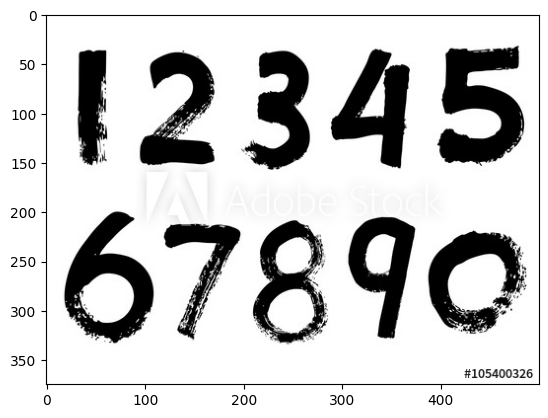

In [9]:
image=np.array(Image.open(IMAGE))
plt.figure()
plt.imshow(image)

## FILTERS DEFINITION

Here we defines our sample filter masks.

In [10]:
filter1=np.array([
    [0,0,0,0,0],
    [0,0,0,0,0],
    [0,0,1,0,0],
    [0,0,0,0,0],
    [0,0,0,0,0]
])
filter2=np.array([[0.5, 0 , -0.5]])
filter3=np.array([[0.5],[0],[-0.5]])

filter4=np.array([
    [1,2,1],
    [0,0,0],
    [-1,-2,-1]
])
filter5=np.array([
    [0.00078633,0.00655965,0.01330373,0.00655965,0.00078633],
    [0.00655965,0.05472157,0.11098164,0.05472157,0.00655965],
    [0.01330373,0.11098164,0.22508352,0.11098164,0.01330373],
    [0.00655965,0.05472157,0.11098164,0.05472157,0.00655965],
    [0.00078633,0.00655965,0.01330373,0.00655965,0.00078633]
])

## FILTER KERNEL

Here you have to define your image_filter GPU kernel.

In [11]:
kernel  =  """
__global__ void image_filter( float * src_image,          //Source GPU array floating point 32 bits,
		                          float * filter_mask,    //Filter Mask GPU array 2D floating point 32 bits
                              float * dst_image,  //Target GPU array 2D floating point 32 bits,
                              int NumRowsImg,         //Image Numrows,
                              int NumColsImg,         //Int32 Image Numcolumns,
                              int NumRowsFilter,       //Int32 Image NumRows filter mask,
                              int NumColsFilter       //Int32 Image NumCols filter mask
                              )
{
  //This instruction calculate in the offset in the memory data, based on the block identificator blockIdx.x
  // YOU HAVE TO WRITE HERE YOUR FILTER KERNEL USING TILED MEMORY ALGORITHMS

    //THIS CODE JUST COPY THE SOURCE IMAGE IN THE TARGET VECTOR
    int idxY; // The thread is going to modify this ROW element of the matrix that we have filtered.
    int idxX; // The thread is going to modify this COLUMN element of the matrix that we have filtered.
    int vX;   // The thread is going to modify this VECTOR element of the matrix that we have filtered.


    idxY = blockIdx.y*blockDim.y+threadIdx.y; //With this we calculate the row address in target matrix
    idxX = blockIdx.x*blockDim.x+threadIdx.x; // With this we calculate the column address in target matrix

  // blockIdx.x, and blockIdx.y are used to indicate the respective block index of the thread:
  // x_coord and y_coord respectively.
  // threadIdx.x and  threadIdx.y show the index of the thread:
  // x_coord and y_coord respectively.
  // This block and thread indeces are provided by the GPU.


  // We are going to use a shared variable matrix as always, that is gonna be used by all the threads.
  // Threads will only be required to access the shared_variable_filter in a local manner, which is faster than accessing the global one.

    if ((idxX < NumRowsImg) && (idxY < NumColsImg))
    {
        vX = idxY * NumColsImg + idxX;
    }
    // Here we have calculated the position of the vector in the filtered matrix

    // Here we are going to create the shared variable, src_image_for_threads, that is going to be accessed by
    // all the threads and that as we explained above, will allow us to get the filtered image faster
    // as each thread does not need to access the global memory.

    // We are going to keep the src_image data so that each thread can collect it
    // In order to ensure that the size of the block is proportional to the size of the image, it is necessary to
    // have at least the size of the pixel in the center of the block. When calculating the filtered result, the
    // part of the image that needs to be multiplied with the filter will be in the middle of the block.

    // But we should notice that the pixels near the edge of the block need to be able to access rows and columns that are not
    //  within the block's boundaries. To address this issue, the size of the tile_src_image must be increased.
    //  This will require taking into account the number of lines and columns in the filter.
    __shared__ float src_image_for_threads[%(block_size)s + %(filter_rows)s - 1][%(block_size)s + %(filter_cols)s - 1];

    int border_x = NumColsFilter / 2; // Border of x
    int border_y = NumRowsFilter / 2; // Border of y

    //**************************************************************************************************************************//
    // We are going to start filling up the matrix, part by part. First the inside part and then the outside part.
    //**************************************************************************************************************************//

    // Here we have declared the integer variables that are going to be used many times though the process
    // of filling up the matrix, this allows to make our code easier to read.

    int x_threshold = blockDim.x - border_x - 1, y_threshold = blockDim.y - border_y - 1;
    // Threshold for x and y
    int symmetric_Bx_Ty = blockDim.x - threadIdx.y - 1, symmetric_Bx_Tx = blockDim.x - threadIdx.x - 1;
    // Symmetric element of Block i and Thread j
    int blockIdx_y_plus_1 = blockIdx.y + 1, blockIdx_y_minus_1 = blockIdx.y - 1;
    // Increment and Decrement of row and column of one unit in the id of the Block x
    int blockIdx_x_plus_1 = blockIdx.x + 1, blockIdx_x_minus_1 = blockIdx.x - 1;
    // Increment and Decrement of row and column of one unit in the id of the Block y
    int row_index = threadIdx.y, col_index = threadIdx.x;

    //**************************************************************************************************************************//

    // 1.) FILL THE INSIDE PART OF THE MATRIX:

    src_image_for_threads[border_y + threadIdx.y][border_x + threadIdx.x] = src_image[vX];
    // Here we are filling each of the src_image_for_threads with the element in vX, the one
    // that corresponds to that image and that it is inside the vX vector. Each thread will access it.

    //**************************************************************************************************************************//

    // 2.) FILL THE OUTSIDE PART OF THE MATRIX:

    // 2.1) FILLING UP THE UPPER border of src_image_for_threads
    if (threadIdx.y < border_y)
    {
     // Here we go to the block above this one and get the symmetrical element from that one in relation to the thread.
     // Use blockIdx() * blockDim() to move to the previous one. Use symmetrical_Bx() * numCols() to find the beginning of the block.
     // Use idxX to find the corresponding symmetric thread in the upper block in relation to its current position.
        int upper_sym = idxX + (symmetric_Bx_Ty + blockIdx_y_minus_1 * blockDim.y) * NumColsImg;
        int symmetric_position = blockIdx_y_minus_1 * blockDim.y + symmetric_Bx_Ty;
        int border = (blockIdx.y * blockDim.y) * NumColsImg + idxX;

     // Filling up the memory:
        row_index = border_y - threadIdx.y - 1;
        col_index = border_x + threadIdx.x;

        if (symmetric_position < 0)
        { // If position is negative, thread is on top of the source image
            src_image_for_threads[row_index][col_index] = src_image[border];
            // Here we are filling the top out border
        }
        else
        {
            src_image_for_threads[row_index][col_index] = src_image[upper_sym];
            // Here we are using the upper value that is symmetric.
        }
    }


    // 2.2)  FILLING UP THE LOWER BORDER of src_image_for_threads
    if (threadIdx.y > y_threshold)
    {// Here we go to the block below this one and get the symmetrical element from that one in relation to the thread.
     // Use f blockIdx_y_plus_1 * blockDim.y to move to the next one.
     // Use symmetric_Bx_Ty to find the beginning of the block.
     // Use idxX to find the corresponding symmetric thread in the lower block in relation to its current position.
        int lower_sym = (blockIdx_y_plus_1 * blockDim.y + symmetric_Bx_Ty) * NumColsImg + idxX;
        int symmetric_position = blockIdx_y_plus_1 * blockDim.y + symmetric_Bx_Ty;
        int border = (blockIdx.y * blockDim.y + (blockDim.y - 1)) * NumColsImg + idxX;

        row_index = (blockDim.y - threadIdx.y) * 2 + threadIdx.y + border_y - 1;
        col_index = border_x + threadIdx.x;

        if (symmetric_position >= NumColsImg)
        {// If position is larger than the columns, thread is on a lower border of the source image
            src_image_for_threads[row_index][col_index] = src_image[border];
            // Here we are filling the out border
        }
        else
        {
            src_image_for_threads[row_index][col_index] = src_image[lower_sym];
            // Here we are using the lower value that is symmetric.
        }
    }

    // 2.3) FILLING UP THE LEFT BORDER of src_image_for_threads
    if (threadIdx.x < border_x)
    {// Here we get the symmetrical element from that one in relation to the thread.
     // Use blockIdx_x_minus_1 * blockDim.x to move to the previous one.
     // Use symmetric_Bx_Tx  to find the end of the block.
        int sym_left = idxY * NumColsImg + blockIdx_x_minus_1 * blockDim.x + symmetric_Bx_Tx;
        int symmetric_position = sym_left - idxY * NumColsImg;
        int border = idxY * NumColsImg;

        row_index = border_y + threadIdx.y;
        col_index = border_x - threadIdx.x - 1;

        if (symmetric_position < 0)
        {// If position is larger negative, thread is on a lower border of the source image
            src_image_for_threads[row_index][col_index] = src_image[border];
        }
        else
        {
            src_image_for_threads[row_index][col_index] = src_image[sym_left];
             // Here we are using the value that is symmetric.
        }
    }

    // 2.4) FILLING UP THE RIGHT BORDER of src_image_for_threads
    if (threadIdx.x > x_threshold)
    {// Here we get the symmetrical element from that one in relation to the thread.
     // UseblockIdx_x_minus_1 * blockDim.x to move to the next one.
     // Use symmetric_Bx_Tx  to find the end of the block.
     // idxY * NumColsImg gives us where the block starts.

        int sym_right = idxY * NumColsImg + blockIdx_x_plus_1 * blockDim.x + symmetric_Bx_Tx;
        int symmetric_position = sym_right - idxY * NumColsImg;
        int border = idxY * NumColsImg + NumColsImg - 1;

        row_index = border_y + threadIdx.y;
        col_index = (blockDim.x - threadIdx.x) * 2 + threadIdx.x + border_x - 1;

        if (symmetric_position >= NumColsImg)
        {// If position is larger than the columns, thread is on a border of the source image
            src_image_for_threads[row_index][col_index] = src_image[border];
        }
        else
        {
            src_image_for_threads[row_index][col_index] = src_image[sym_right];
            // Here we are using the rigth value, that is symmetric.

        }
    }

    //**************************************************************************************************************************//

    // 3. FILL THE CORNERS OF THE MATRIX:

    // 3.1) FILLING UP THE LOWER LEFT CORNER of src_image_for_threads
    if (threadIdx.x < border_x && threadIdx.y > y_threshold)
    {
        int lower_left_corner = (blockIdx_y_plus_1 * blockDim.y + symmetric_Bx_Ty) * NumColsImg + blockIdx_x_minus_1 * blockDim.x + (blockDim.x - threadIdx.x - 1);
        // Here  blockIdx_y_plus_1*blockDim.y + symmetric_Bx_Ty)*NumColsImg is the next row
        // blockIdx_x_minus_1*blockDim.x + (blockDim.x-threadIdx.x-1)
        // is the symmetric value of the previous block in the next row of the thread.

        int y_location = blockIdx_y_plus_1 * blockDim.y + symmetric_Bx_Ty;
        int x_location = blockIdx_x_minus_1 * blockDim.x + symmetric_Bx_Tx;
        int corner = (blockIdx.y * blockDim.y + (blockDim.y - 1)) * NumColsImg + blockIdx.x * blockDim.x;

        row_index = blockDim.y - 1;
        col_index = border_x - threadIdx.x - 1;

        if (y_location >= NumColsImg || x_location < 0)
        {// If position is larger than the columns, thread is on a left border of the source image
            src_image_for_threads[row_index][col_index] = src_image[corner];
        }
        else
        {
            src_image_for_threads[row_index][col_index] = src_image[lower_left_corner];
            // Here we are filling with the lower left value.
        }
    }

    // 3.2) FILLING UP THE LOWER RIGHT CORNER of src_image_for_threads
    if (threadIdx.x > (blockDim.x - border_x - 1) && threadIdx.y > y_threshold)
    {
        int lower_right_corner = (blockIdx_y_plus_1 * blockDim.y + symmetric_Bx_Ty) * NumColsImg + blockIdx_x_plus_1 * blockDim.x + (blockDim.x - threadIdx.x - 1);
        // Here  blockIdx_y_plus_1*blockDim.y + symmetric_Bx_Ty)*NumColsImgis the next row
        // blockIdx_x_plus_1*blockDim.x + (blockDim.x-threadIdx.x-1)
        // is the symmetric value of the next block in the next row of the thread.

        int y_location = blockIdx_y_plus_1 * blockDim.y + symmetric_Bx_Ty;
        int x_location = blockIdx_x_plus_1 * blockDim.x + symmetric_Bx_Tx;
        int corner = (blockIdx.y * blockDim.y) * NumColsImg + NumColsImg - 1;

        row_index = (blockDim.y - 1) + border_y + (blockDim.y - threadIdx.y);
        col_index = (blockDim.x - 1) + border_x + (blockDim.x - threadIdx.x);

        if (y_location >= NumColsImg || x_location >= NumColsImg)
        {// If position is larger than the columns, thread is on a right border of the source image
            src_image_for_threads[row_index][col_index] = src_image[corner];
        }
        else
        {
            src_image_for_threads[row_index][col_index] = src_image[lower_right_corner];
            // Here we are filling with the lower right value.

        }
    }

    // 3.3)  FILLING UP UPPER LEFT CORNER of src_image_for_threads
    if (threadIdx.x < border_x && threadIdx.y < border_y)
    {
        int up_left_corner = (blockIdx_y_minus_1 * blockDim.y + symmetric_Bx_Ty) * NumColsImg + blockIdx_x_minus_1 * blockDim.x + (blockDim.x - threadIdx.x - 1);
        // Here  blockIdx_y_minus_1*blockDim.y + symmetric_Bx_Ty)*NumColsImg is the top row
        // blockIdx_x_minus_1*blockDim.x + (blockDim.x-threadIdx.x-1)
        // is the symmetric value of the previous block symmetric with respect to x.
        int y_location = blockIdx_y_minus_1 * blockDim.y + symmetric_Bx_Ty;
        int x_location = blockIdx_x_minus_1 * blockDim.x + symmetric_Bx_Tx;
        int corner = (blockIdx.y * blockDim.y) * NumColsImg + blockIdx.x * blockDim.x;

        row_index = threadIdx.y;
        col_index = threadIdx.x;

        if (y_location < 0 || x_location < 0)
        {// If position is larger than the columns, thread is pointing to a corner of the source image
            src_image_for_threads[row_index][col_index] = src_image[corner];
        }
        else
        {
            src_image_for_threads[row_index][col_index] = src_image[up_left_corner];
            // Here we are in a corner of the src_image so we fill it with the exact same value.
        }
    }

    // 3.4) FILLING UP UPPER RIGHT CORNER of src_image_for_threads
    if (threadIdx.x > x_threshold && threadIdx.y < border_y)
    {
        int up_rigth_corner = (blockIdx_y_minus_1 * blockDim.y + symmetric_Bx_Ty) * NumColsImg + blockIdx_x_plus_1 * blockDim.x + (blockDim.x - threadIdx.x - 1);
        // Here  blockIdx_y_minus_1*blockDim.y + symmetric_Bx_Ty)*NumColsImg is the previous row
        // blockIdx_x_plus_1*blockDim.x + (blockDim.x-threadIdx.x-1)
        // is the symmetric value of the next block symmetric with respect to x.
        int y_location = blockIdx_y_minus_1 * blockDim.y + symmetric_Bx_Ty;
        int x_location = blockIdx_x_plus_1 * blockDim.x + symmetric_Bx_Tx;
        int corner = (blockIdx.y * blockDim.y) * NumColsImg + NumColsImg - 1;

        row_index = threadIdx.y;
        col_index = (blockDim.x - 1) + border_x + (blockDim.x - threadIdx.x);

        if (y_location < 0 || x_location >= NumColsImg)
        {// If position is larger than the columns, thread is pointing to a corner of the source image
            src_image_for_threads[row_index][col_index] = src_image[corner];
            // Fill with corner value.
        }
        else
        {
            src_image_for_threads[row_index][col_index] = src_image[up_rigth_corner];
            // Here we fill with the up_rigth_corner value.
        }
    }

    //**************************************************************************************************************************//


    // Now we are going to create the shared_variable_filter again, with size the one of the filter and that will be also
    // access by all the threads with correct positions. They will copy down here the values from the global variable.
    __shared__ float shared_variable_filter[%(filter_rows)s][%(filter_cols)s];

    if ((threadIdx.x < NumColsFilter) && (threadIdx.y < NumRowsFilter))
    {
        int vector_filter_mask = threadIdx.x + threadIdx.y * NumColsFilter;
        // For each column and row we create this vector_filter_mask

        shared_variable_filter[threadIdx.y][threadIdx.x] = filter_mask[vector_filter_mask];
    }

    //**************************************************************************************************************************//

    __syncthreads(); // Stop until all the threads to have finished filling the memory

    //**************************************************************************************************************************//

    double cummulated_sum = 0;
    // Here we are going through the rows and columns of the filter:
    for (int row = 0; row < NumRowsFilter; row++)
    {
        for (int col = 0; col < NumColsFilter; col++)
        {
            cummulated_sum += shared_variable_filter[row][col] * src_image_for_threads[row + threadIdx.y][col + threadIdx.x];
        // cummulated_sum stores the total cummulated sum of the elements with respect to the filter
        }
    }

    // Finally we must be sure that the position is correct:
    if ((threadIdx.y < NumRowsImg) && (threadIdx.x < NumColsImg))
    {
        dst_image[vX] = cummulated_sum;
    }
    // When the position is correct, we can keep in this vector the element filtered
}

"""

And import the kernel definition to python

## SETUP EXPERIMENT

Recover the image shape, and select the two first items (rows and columns).

In [12]:
image_shape=image.shape[0:2]

Set block size and grid size.

In [13]:
block_s=16
block_size=(block_s,block_s,1)
grid_size=(int(np.ceil(image_shape[1]/block_s)),int(np.ceil(image_shape[0]/block_s)))

Allocates the target image memory.

In [14]:
result_image=np.zeros(image.shape,dtype=np.uint8)

In [15]:
depth = image.shape[2]

### Select the filter mask, and upload to the GPU device.

In [16]:
filter_mask=filter2.astype(np.float32) # Here we can choose any filter from the ones with have
filter_mask_gpu=gpuarray.to_gpu(filter_mask)

In [17]:
kernel_code = kernel % {
    'filter_rows': filter_mask.shape[0],
    'filter_cols': filter_mask.shape[1],
    'block_size': block_s,
}
# compile the kernel code
kernel = SourceModule(kernel_code)

In [18]:
image_filter = kernel.get_function('image_filter')

## Prepares the execution environment

Allocate the temporal filtered memory layer, where will be store the filtered image.

In [19]:
filtered_image_layer_gpu = gpuarray.zeros(image_shape,np.float32)

Here defines the main block.
Walk through the layers. Copying the selected layer to temporal image_layer, upload the layer to the GPU and invokes the image_filter kernel.

In [20]:
%%timeit -r 10 -n 10 -o
for layer in range(depth):
  image_layer = np.zeros(image_shape,dtype=np.float32) #Allocate the temporal image layer
  image_layer=(image[:,:,layer]).astype(np.float32)    #Copy from the orignal image the selected layer into the temporal memory
  image_layer_gpu=gpuarray.to_gpu(image_layer)         #Uploads the image layer to the GPU
  filtered_image_layer_gpu.fill(0.0)                   #Fills with 0 the target memory in the GPU
  image_filter(                                        #invokes the kernel
          image_layer_gpu,
          filter_mask_gpu,
          filtered_image_layer_gpu,
          np.int32(image_shape[0]),
          np.int32(image_shape[1]),
          np.int32(filter_mask.shape[0]),
          np.int32(filter_mask.shape[1]),
          block=block_size,
          grid=grid_size
        )
  filtered_image_layer=filtered_image_layer_gpu.get() #Download from the GPU the filtered image
  result_image[:,:,layer] = filtered_image_layer.astype(np.uint8) #Copy the filtered image to the final image store,
                                                                  #casting the data type from double to uint8

5.13 ms ± 426 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


<TimeitResult : 5.13 ms ± 426 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)>

*NOTE* The follow code fetch from the stack the exectution statistics produced by the magic metacommand %%timeit and stores it in a python variable.

In [21]:
statistics=_ # This code is correct, as it says in the NOTE, it is storing the full statistics of the above code, that we are going to plot now:

# Show results


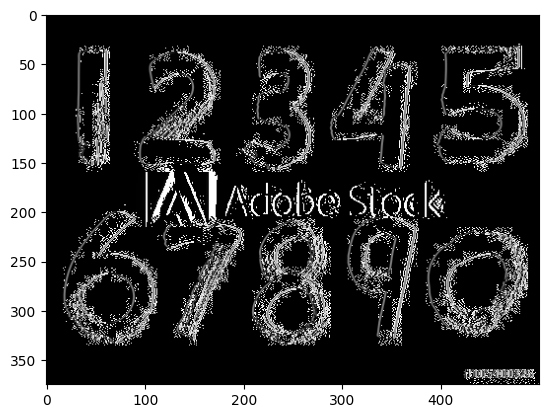

In [22]:
plt.figure()
plt.imshow(result_image)

In [23]:
print("Best execution time: {}".format(statistics.best))
print("Worst execution time: {}".format(statistics.worst))
print("Mean execution time: {mean} ({stdev} std dev)".format(mean=statistics.average,stdev=statistics.stdev))

Best execution time: 0.004691728699981468
Worst execution time: 0.006176771299942629
Mean execution time: 0.005132002899972577 (0.0004259386863843708 std dev)


# Alejo´s Personal Conclusions